
Fit SBFGauss1D10R
=========================================
In this example, we simulate a unidimensional (ground truth) MHP with a multimodal Gaussian kernel with three modes.

We estimate the parameters of this MHP using ASLSD, with a SBF Gaussian model with 10 modes, where the true model is not within the parametric family considered.

In [1]:
import os
import sys

# add the path of packages to system path
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

% matplotlib inline

from aslsd.basis_kernels.basis_kernel_gaussian import GaussianKernel
from aslsd.kernels.kernel import KernelModel
from aslsd.models.mhp import MHP

We first specify our ground-truth model, and its parameter values.

In [2]:
# Define a ground truth MHP
true_kernel = KernelModel([GaussianKernel(), GaussianKernel(),
                           GaussianKernel()])
true_mhp = MHP([[true_kernel]])

# Define true parameter values
true_mu = np.array([0.01])
true_omega = np.array([0.2, 0.3, 0.4])
true_beta = np.array([0.4, 0.6, 0.8])
true_delta = np.array([1., 3., 8.])

true_ker_param = [[np.zeros(9)]]
for ix in range(3):
    true_ker_param[0][0][3*ix] = true_omega[ix]
    true_ker_param[0][0][3*ix+1] = true_beta[ix]
    true_ker_param[0][0][3*ix+2] = true_delta[ix]

Next, we simulate a single path of this process, over a long horizon.

In [3]:
T_f = 10**7
list_times = true_mhp.simulate(T_f, mu=true_mu, kernel_param=true_ker_param,
                               seed=1234, verbose=True)

Simulating events...
Simulation Complete,  994851  events simulated.


We visualize the simulated data

C:\Users\samue\AppData\Local\Temp/ipykernel_16476/1934311958.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


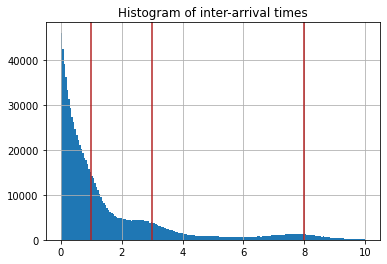

In [4]:
inter_arrivals = pd.Series(list_times[0][1:]-list_times[0][:-1])
fig = plt.figure()
inter_arrivals[inter_arrivals < 10].hist(bins=200)
for z in true_delta:
    plt.axvline(x=z, color='firebrick')
plt.title('Histogram of inter-arrival times')


We next define a new model (of SBF type), and estimate its parameters using the ASLSD algorithm.

In [5]:
# Define a model
basis_kernels = [GaussianKernel(fixed_indices=[1, 2],
                                fixed_vars=[0.5, float(ix_bk)])
                 for ix_bk in range(10)]
kernel = KernelModel(basis_kernels)
mhp = MHP([[kernel]])

# Fit the model
kwargs = {'is_log_param': True, 'is_log_grad': True}
mhp.fit(list_times, T_f, n_iter=1000, seed=12, verbose=True, **kwargs)
fit_log = mhp.fit_log

100%|██████████| 1000/1000 [14:01<00:00,  1.19it/s]


For comparison, we compute the L2 optimal approximation of the true model within the SBF parametric family.

In [6]:
# L2 projection of the model
res = mhp.get_l2_projection(true_mhp, true_ker_param, n_iter=1000,
                            log_error=True, verbose=True)
l2_projection_params = res['params']

100%|██████████| 1000/1000 [00:04<00:00, 225.36it/s]


Finally, we plot the fitted and ground-truths kernels, and the path of the solver.

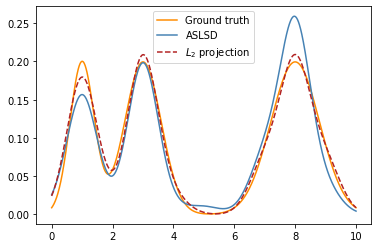

In [9]:
# Visualize results
fig = plt.figure()
t = np.linspace(0, 10, 1000)
true_y = true_kernel.phi(t, true_ker_param[0][0])
plt.plot(t, true_y, color='darkorange', label='Ground truth')
y = mhp.phi[0][0](t, mhp.fitted_ker_param[0][0])
plt.plot(t, y, color='steelblue', label='ASLSD')
l2_proj_y = mhp.phi[0][0](t, l2_projection_params[0][0])
plt.plot(t, l2_proj_y, color='firebrick', linestyle='dashed',
         label=r'$L_2$ projection')
_=plt.legend()
